# CS6140 Machine Learning: Assignment 3 (F22) (Total Points: 100)
## Prof. Ahmad Uzair


# ROC and Precision Recall curves

1. Generate data: Simulate a binary classification problem by generating a vector of class labels. Size 100. Generate a vector of predictor estimates using a random number generator. **(5 Points)**

2. Calculate and plot ROC and Precision-Recall curves. **(20 Points)**

3. Match your curve generated with sklearn. **(5 Points)**



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from collections import defaultdict
from IPython.display import display
from scipy.cluster.hierarchy import dendrogram

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 16)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000, 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8, 11, 14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]

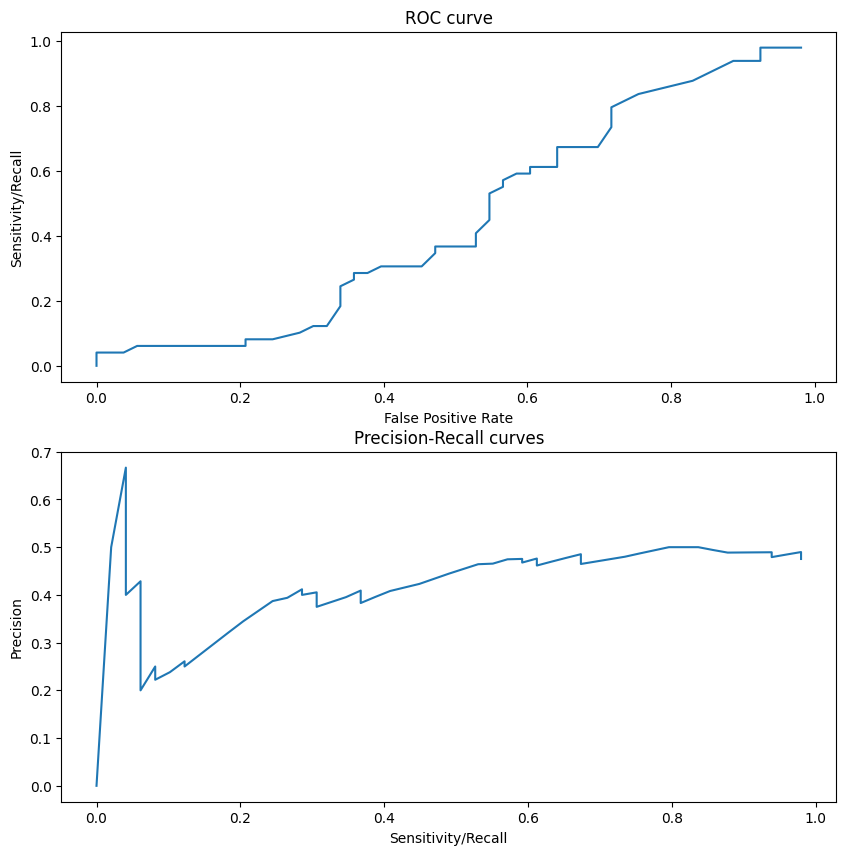

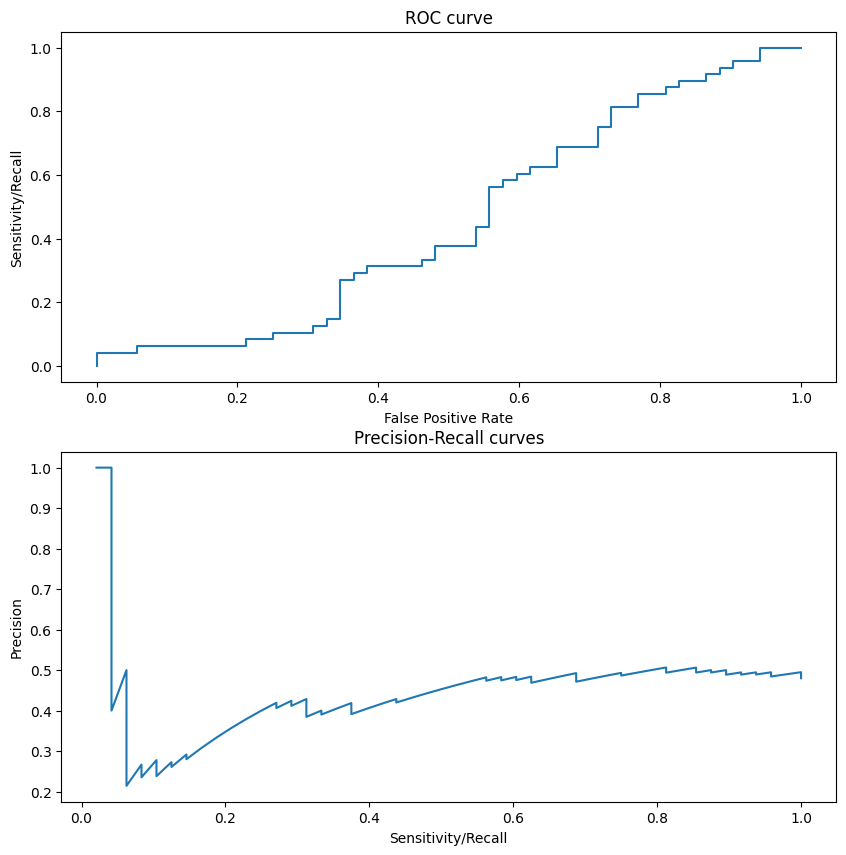

In [3]:
# 1.
labels = np.random.randint(2, size = 100)
estimates = np.random.uniform(0, 1, size = 100)
zipped_est = list(zip(labels, estimates))
zipped_est.sort(key = lambda x: x[1])

# 2.
fp_rate = []
sensitivities = []
precision = []
thre_prc_ = np.linspace(0, 1, 100)

# Use the same thresholds from sklearn function to make sure the performance between implementation from scratch and build-in function is comparable
pre, rec, thre_prc = metrics.precision_recall_curve(labels, estimates, pos_label = 1)
# print(len(thre_prc))

for c in thre_prc_:
    confusion_matrix = defaultdict(int)
    for i, j in zipped_est:
        if i == 1:
            if j >= c:
                confusion_matrix['TP'] += 1
            else:
                confusion_matrix['FN'] += 1
        else:
            if j >= c:
                confusion_matrix['FP'] += 1
            else:
                confusion_matrix['TN'] += 1
    fp_rate.append(np.round(confusion_matrix['FP'] / (confusion_matrix['FP'] + confusion_matrix['TN'] + 1), 8))
    sensitivities.append(np.round(confusion_matrix['TP'] / (confusion_matrix['TP'] + confusion_matrix['FN'] + 1), 8))
    precision.append(np.round(confusion_matrix['TP'] / (confusion_matrix['TP'] + confusion_matrix['FP'] + 1), 8))

fig_2 = plt.figure(figsize = (10, 10), dpi = 100)
ax = fig_2.add_subplot(2, 1, 1)
ax.plot(fp_rate, sensitivities, axes = ax)
ax.set_title('ROC curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Sensitivity/Recall')

ax = fig_2.add_subplot(2, 1, 2)
plt.plot(sensitivities, precision, axes = ax)
ax.set_title('Precision-Recall curves')
ax.set_xlabel('Sensitivity/Recall')
ax.set_ylabel('Precision')
plt.show()

# 3.
fpr, tpr, thre_roc = metrics.roc_curve(labels, estimates, pos_label = 1)

fig_3 = plt.figure(figsize = (10, 10), dpi = 100)
ax = fig_3.add_subplot(2, 1, 1)
ax.plot(fpr, tpr, axes = ax)
ax.set_title('ROC curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Sensitivity/Recall')

ax = fig_3.add_subplot(2, 1, 2)
ax.plot(rec[: -1], pre[: -1], axes = ax)
ax.set_title('Precision-Recall curves')
ax.set_xlabel('Sensitivity/Recall')
ax.set_ylabel('Precision')
plt.show()

# Random Forest classifier 
1. Load iris data set.

```{python}
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
```

Investigate following parameters of Random Forest classifier and tune them using Randomized Search and Grid Search. 

```{python}
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8, 11,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
```
2. Use seed 1 to split data in 80-20 train-test configuration.  Train a Random Forest classifier with each unique configuration and record train/test accuracy, precision and recall in the results dataframe. This dataframe will have 5 columns (each corresponding to tuning parameter) and each row will correspond to each unique configuration. 5x5x5x5x5 rows. Analyse of the impact of each tuning parameter on predictor performance. **(15 Points)**

3. From the results of the above find the best estimators and use them for classifcation once again and evaluate the performance using 10 fold cross validation. **(15 Points)**



In [4]:
# 1.
iris = load_iris()
X = iris.data
y = iris.target

In [5]:
# 2.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
rfc = RandomForestClassifier(random_state = 1)
params = {'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf}
# precision_score = metrics.make_scorer(precision, average = 'weighted')
scores = {'accuracy': 'accuracy', 'precision': metrics.make_scorer(metrics.precision_score, average = 'weighted'), 'recall':  metrics.make_scorer(metrics.recall_score, average = 'weighted')}
gridsearch_rfc = GridSearchCV(estimator = rfc,
                              param_grid = params,
                              scoring = scores,
                              refit = 'precision',
                              n_jobs = -1)
gridsearch_rfc.fit(X_train, y_train)
res = pd.concat([pd.DataFrame(gridsearch_rfc.cv_results_['params']),
                 pd.DataFrame(gridsearch_rfc.cv_results_['mean_test_accuracy'], columns = ['Accuracy']),
                 pd.DataFrame(gridsearch_rfc.cv_results_['mean_test_precision'], columns = ['Precision']),
                 pd.DataFrame(gridsearch_rfc.cv_results_['mean_test_recall'], columns = ['Recall'])],
                axis = 1)
display(res)

,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,Accuracy,Precision,Recall
0,10,auto,1,2,5,0.958333,0.963102,0.958333
1,10,auto,1,2,6,0.966667,0.970394,0.966667
2,10,auto,1,2,7,0.966667,0.970394,0.966667
3,10,auto,1,2,8,0.950000,0.960185,0.950000
4,10,auto,1,2,9,0.966667,0.970394,0.966667
...,...,...,...,...,...,...,...,...
11995,1000,log2,8,14,16,0.958333,0.961134,0.958333
11996,1000,log2,8,14,17,0.950000,0.955463,0.950000
11997,1000,log2,8,14,18,0.950000,0.960185,0.950000
11998,1000,log2,8,14,19,0.950000,0.955463,0.950000


In [6]:
# 3.
best_params = gridsearch_rfc.best_params_
print('Best parameters:')
for key in best_params:
    print(key, ': ', best_params[key])
best_rfc = RandomForestClassifier(random_state = 1,
                                  n_estimators = best_params['n_estimators'],
                                  max_depth = best_params['max_depth'],
                                  max_features = best_params['max_features'],
                                  min_samples_split = best_params['min_samples_split'],
                                  min_samples_leaf = best_params['min_samples_leaf'])
best_scores = cross_val_score(best_rfc, X_test, y_test, cv = 10)
print('\nCross Validation Scores:\n', best_scores)
print('\nAverage Cross Validation Score:\n', sum(best_scores) / len(best_scores))

Best parameters:
max_depth :  10
max_features :  auto
min_samples_leaf :  1
min_samples_split :  2
n_estimators :  6

Cross Validation Scores:
 [0.66666667 1.         1.         1.         1.         1.
 1.         1.         1.         0.66666667]

Average Cross Validation Score:
 0.9333333333333332


# Heirarchical Agglomerative Clustering HAC

Load iris dataset from sklearn.
```{python}
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
```
1. Implement HAC algorithm. Use the abstract class definition provided below. **(15 Points)**

2. Test your code first with uni-variate data as following; **(10 Points)**
```{python}
x = {'JAN':31.9, 'FEB':32.3, 'MAR':35, 'APR':52, 'MAY':60.8, 'JUN':68.7, 'JUL':73.3, 'AUG':72.1, 'SEP':65.2, 'OCT':54.8, 'NOV':40, 'DEC':38}
hac = HAC(param={'dist': 'eucl'})
hac.fit(x)
for c in hac.dendrogram:
    print(c)
```
Expected output:
```
(0, ['JAN', 'FEB'], 0.4)
(1, ['JUL', 'AUG'], 1.2)
(2, ['NOV', 'DEC'], 2.0)
(3, ['APR', 'OCT'], 2.8)
(4, ['JAN', 'FEB', 'MAR'], 2.9)
(5, ['JUN', 'SEP'], 3.5)
(6, ['APR', 'OCT', 'MAY'], 7.4)
```

2. Fit the HAC model to iris dataset. Print the heirarchy of clusters creatively. It need not to be a dendrogram but you can use [sklearn implementation](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py) for comparison. **(15 Points)**



In [7]:
def get_sub_clusters(set_1, cands):
    remain = set_1
    sub_clusters = []
    for i in range(len(cands) - 1, -1, -1):
        if cands[i].issubset(remain):
            remain = remain.difference(cands[i])
            sub_clusters.append(i)
    return sub_clusters



class HAC:
    def __init__(self, X, param):
        self.X = X
        self.__distances__(param['dist'])

    def get_cluster_dis(self, vec1, vec2):
        dis = 0
        for i in vec1:
            for j in vec2:
                dis += self.C[i][j]
        return float(dis) / (len(vec1) * len(vec2))

    def __distances__(self, dist = 'eucl'):
        """
        Implement __distances__ method to caculate pair-wise distances
        among datapoint in X with respect to distance measures
        - eucl : eucledean distance
        - manh : manhattan
        - mink : minkownski
        """
        if dist not in ['eucl', 'manh', 'mink']:
            raise Exception('Not a valid dist measure. Choose among eucl, manh, mink')

        distance_metrix = []
        for vec1 in self.X:
            dis = []
            for vec2 in self.X:
                if dist == 'eucl':
                    dis.append(distance.euclidean(vec1, vec2))
                elif dist == 'manh':
                    dis.append(distance.cityblock(vec1, vec2))
                else:
                    dis.append(distance.minkowski(vec1, vec2, 2))
            distance_metrix.append(dis)

        self.C = np.array(distance_metrix)

    def __merge__(self):
        """
        Implement __merge__ method to recursively merge the nearest datapoints in X
        using pair-wise distances matrix X.
        Save the merge results at each iteration/'recursive call'
        in dendrogram list of clusters.
        """
        cluster_num = len(self.X)
        self.cluster_set = []
        self.additional_sets = {}
        self.linkage_matrix = []
        for i in range(cluster_num):
            self.cluster_set.append(frozenset([i]))
            self.additional_sets[frozenset([self.labels[i]])] = {i}

        def helper(clusters, no):
            if len(clusters) == 1:
                return
            clus = []
            nearest = float('inf')
            m1 = m2 = -1
            for i in range(len(clusters) - 1):
                for j in range(i + 1, len(clusters)):
                    curr_dis = self.get_cluster_dis(clusters[i][1], clusters[j][1])
                    if curr_dis < nearest:
                        nearest = curr_dis
                        m1, m2 = i, j

            merged = clusters.pop(m2)

            new_set = frozenset([self.cluster_set.index(self.additional_sets[frozenset(merged[0])]), self.cluster_set.index(self.additional_sets[frozenset(clusters[m1][0].copy())])])
            self.cluster_set.append(new_set)

            clusters[m1][0] += merged[0]
            self.linkage_matrix.append(list(new_set) + [nearest] + [len(clusters[m1][0])])
            self.additional_sets[frozenset(clusters[m1][0])] = new_set

            self.dendrogram.append((no, clusters[m1][0].copy(), np.round(nearest, 2)))

            helper(clusters, no + 1)

        clu = list(map(lambda x, y: [x, y], [[lab] for lab in self.labels], [[i] for i in range(len(self.labels))]))
        helper(clu, 0)
        self.cluster_set = self.cluster_set[cluster_num:]

    def __display__(self):
        """
        Implement __display__ method to cretively show the contents of dendrogram.
        """
        pass

    def fit(self, X):
        self.X = list(X.values())
        self.labels = list(X.keys())
        self.__distances__()
        self.dendrogram = list()
        self.__merge__()

In [8]:
x = {'JAN': 31.9, 'FEB': 32.3, 'MAR': 35, 'APR': 52, 'MAY': 60.8, 'JUN': 68.7, 'JUL': 73.3, 'AUG': 72.1, 'SEP': 65.2, 'OCT': 54.8, 'NOV': 40, 'DEC': 38}
hac = HAC([[x[key]] for key in x], param = {'dist': 'eucl'})
hac.fit({k: [v] for k, v in x.items()})
for c in hac.dendrogram:
    print(c)

(0, ['JAN', 'FEB'], 0.4)
(1, ['JUL', 'AUG'], 1.2)
(2, ['NOV', 'DEC'], 2.0)
(3, ['APR', 'OCT'], 2.8)
(4, ['JAN', 'FEB', 'MAR'], 3.1)
(5, ['JUN', 'SEP'], 3.5)
(6, ['JUN', 'SEP', 'JUL', 'AUG'], 4.6)
(7, ['MAY', 'JUN', 'SEP', 'JUL', 'AUG'], 7.9)
(8, ['JAN', 'FEB', 'MAR', 'NOV', 'DEC'], 8.1)
(9, ['APR', 'OCT', 'MAY', 'JUN', 'SEP', 'JUL', 'AUG'], 8.8)
(10, ['JAN', 'FEB', 'MAR', 'NOV', 'DEC', 'APR', 'OCT', 'MAY', 'JUN', 'SEP', 'JUL', 'AUG'], 20.1)


In [9]:
hashed_iris = {i: v for i, v in zip(range(len(X)), X)}
hac_iris = HAC(X, param = {'dist': 'eucl'})
hac_iris.fit(hashed_iris)
for c in hac_iris.dendrogram:
    print(c)

(0, [101, 142], 0.0)
(1, [7, 39], 0.1)
(2, [0, 17], 0.1)
(3, [9, 34], 0.1)
(4, [128, 132], 0.1)
(5, [10, 48], 0.1)
(6, [4, 37], 0.14)
(7, [19, 21], 0.14)
(8, [0, 17, 4, 37], 0.14)
(9, [29, 30], 0.14)
(10, [57, 93], 0.14)
(11, [80, 81], 0.14)
(12, [116, 137], 0.14)
(13, [8, 38], 0.14)
(14, [19, 21, 46], 0.14)
(15, [3, 47], 0.14)
(16, [7, 39, 49], 0.14)
(17, [27, 28], 0.14)
(18, [82, 92], 0.14)
(19, [95, 96], 0.14)
(20, [127, 138], 0.14)
(21, [1, 45], 0.14)
(22, [1, 45, 12], 0.14)
(23, [0, 17, 4, 37, 27, 28], 0.14)
(24, [63, 91], 0.14)
(25, [65, 75], 0.14)
(26, [0, 17, 4, 37, 27, 28, 40], 0.17)
(27, [0, 17, 4, 37, 27, 28, 40, 7, 39, 49], 0.17)
(28, [69, 80, 81], 0.17)
(29, [123, 126], 0.17)
(30, [1, 45, 12, 9, 34], 0.17)
(31, [112, 139], 0.17)
(32, [3, 47, 29, 30], 0.17)
(33, [94, 99], 0.17)
(34, [88, 95, 96], 0.17)
(35, [66, 84], 0.2)
(36, [23, 26], 0.2)
(37, [53, 89], 0.2)
(38, [74, 97], 0.2)
(39, [1, 45, 12, 9, 34, 25], 0.22)
(40, [63, 91, 73], 0.22)
(41, [110, 147], 0.22)
(42, [120, 

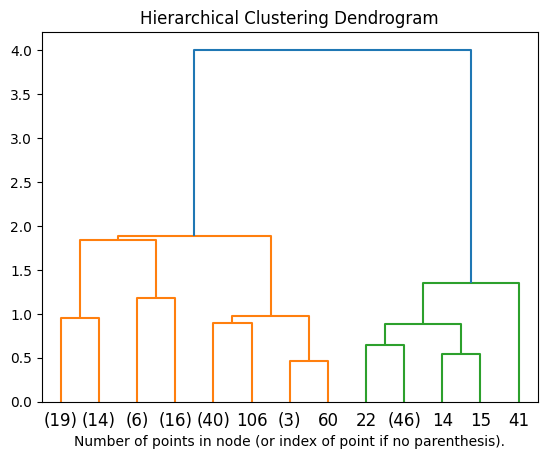

In [10]:
fig = plt.figure()
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(hac_iris.linkage_matrix, truncate_mode = "level", p = 3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()